In [1]:
%matplotlib inline
import os
import requests
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 6, 10 # control plot size

In [2]:
def __mkdir(*args):
    path = os.path.join(*args)
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
    return path

## Set working directory here if different from directory of the ipython notebook

In [3]:
#working_dir = __mkdir(os.path.expanduser("~"), "Medframes")

# Set working directory as the current directory of the ipython notebook
working_dir = os.getcwd()

print("Working directory: %s" % working_dir)

Working directory: C:\Study\CS102\project\project2\repro\CS109Project


In [5]:
data_dir = __mkdir(working_dir, "data")
mm = pd.read_pickle(os.path.join(data_dir, "mm.pckl"))
mm.head(10)

,nct_id,criteria_id,ngram_index,score,term,cui,stype,cid
0,NCT00001149,0,0,11.49,Historical aspects qualifier,C0019665,inpr,[x.x.x]
1,NCT00001149,0,0,8.34,History,C0019664,ocdi,[K01.400]
2,NCT00001149,0,1,17.80,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."
3,NCT00001149,0,3,8.34,Time,C0040223,tmco,[G01.910]
4,NCT00001149,0,7,17.80,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."
5,NCT00001149,0,10,9.95,Historical aspects qualifier,C0019665,inpr,[x.x.x]
6,NCT00001149,0,10,6.79,History,C0019664,ocdi,[K01.400]
7,NCT00001149,0,11,16.26,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."
8,NCT00001149,0,12,16.26,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."
9,NCT00001149,0,14,6.79,Time,C0040223,tmco,[G01.910]


# Download semantic types info

In [4]:
def download_stypes(dest_dir):
    print("Downloading stypes data for to %s" % dest_dir)
    data_url = "https://metamap.nlm.nih.gov/Docs/SemanticTypes_2013AA.txt"

    out_path = os.path.join(dest_dir, "stypes_data.txt")
    with open(out_path, 'w') as f:
        r = requests.get(data_url)
        f.write(r.text)
    return dest_dir

In [5]:
download_dir = __mkdir(working_dir, "download")
download_stypes(download_dir)

'C:\\Study\\CS102\\project\\project2\\repro\\CS109Project\\download'

# Store semantic types in dataframe

In [6]:
def stypes_to_dataframe(src_dir):
    with open(os.path.join(src_dir, "stypes_data.txt")) as f:
        data = []
        for line in f:
            line = line.rstrip('\n')
            st_abbr, st_id, st_full = line.split('|')
            d = {'abbr': st_abbr, 'id': st_id, 'full': st_full}
            data.append(d)
        st_df = pd.DataFrame(data)
        return st_df
    

In [7]:
download_dir = __mkdir(working_dir, "download")
data_dir = __mkdir(working_dir, "data")
stypes_df = stypes_to_dataframe(download_dir)
stypes_df.to_pickle(os.path.join(data_dir, 'stypes.pckl'))

In [8]:
stypes = pd.read_pickle(os.path.join(data_dir, 'stypes.pckl'))
stypes.head()

,abbr,full,id
0,aapp,"Amino Acid, Peptide, or Protein",T116
1,acab,Acquired Abnormality,T020
2,acty,Activity,T052
3,aggp,Age Group,T100
4,amas,Amino Acid Sequence,T087


# Calculate percentages of stypes in mm results

In [9]:
def get_stypes_with_percentages(mm, stypes):
    """
        For each row in metamap tags dataframe, we inc counts in dict with corresponding stypes as keys.
        Then we get full stype name from stypes dataframe, created from downloaded data.
        Returns dataframe with stypes info & percentage.
    """
    counts = mm['stype'].value_counts()
    stypes_freq_dict = {}
    for item in counts.iteritems():
        abbrs = item[0].split(',')
        count = item[1]
        for abbr in abbrs:
            if stypes_freq_dict.get(abbr, None):
                stypes_freq_dict[abbr] += count
            else:
                stypes_freq_dict[abbr] = count
    data = []
    index = []
    for abbr, count in stypes_freq_dict.items():
        full = stypes[stypes['abbr'] == abbr].full.values[0]
        index.append(full)
        d = {'abbr': abbr, 'full': full, 'percentage': round(count*100 / float(mm.shape[0]), 2)}
        data.append(d)
    st_df = pd.DataFrame(data, index)
    return st_df

In [10]:
data_dir = __mkdir(working_dir, "data")
mm = pd.read_pickle(os.path.join(data_dir, "mm.pckl"))
stypes = pd.read_pickle(os.path.join(data_dir, 'stypes.pckl'))
st_df = get_stypes_with_percentages(mm, stypes)
st_df.to_pickle(os.path.join(data_dir, "stypes_percentage.pckl"))

In [11]:
stypes_perc = pd.read_pickle(os.path.join(data_dir, 'stypes_percentage.pckl'))
stypes_perc.head()

,abbr,full,percentage
Population Group,popg,Population Group,3.03
Injury or Poisoning,inpo,Injury or Poisoning,0.43
"Element, Ion, or Isotope",elii,"Element, Ion, or Isotope",0.35
Idea or Concept,idcn,Idea or Concept,0.82
Neoplastic Process,neop,Neoplastic Process,0.94


# Plot results

In [19]:
PLOT_CONF = {
    'threashold': 1, # include stypes with percentage > threashold only
    'mean_line': True,
    'std_plus_line': True,
    'std_mult': 1, # set to 1 for default. set i*std to get 2*std, 3*std intervals
    'std_minus_line': False,
    'title': 'Semantic types frequencies'
}

In [20]:
def plot(st_df, conf):
    st_df[st_df['percentage'] > conf['threashold']].sort_values(by=['percentage']).percentage.plot.barh(fontsize=12, label='Semantic Types with percentage')
    if conf['mean_line']:
        plt.axvline(st_df.percentage.mean(), 0, 1, color='r', label='Average')
    if conf['std_plus_line']:
        plt.axvline(st_df.percentage.mean() + conf['std_mult']*st_df.percentage.std(), 0, 1, color='g', ls='--', label='Average + STD' if conf['std_mult'] == 1 else 'Average + %dSTD' % conf['std_mult'])
    if conf['std_minus_line']:
        plt.axvline(st_df.percentage.mean() - st_df.percentage.std(), 0, 1, color='b', ls='--', label='Average - STD')
    plt.legend(bbox_to_anchor=(2, .94))
    if conf['title']:
        plt.title(conf['title'])
    

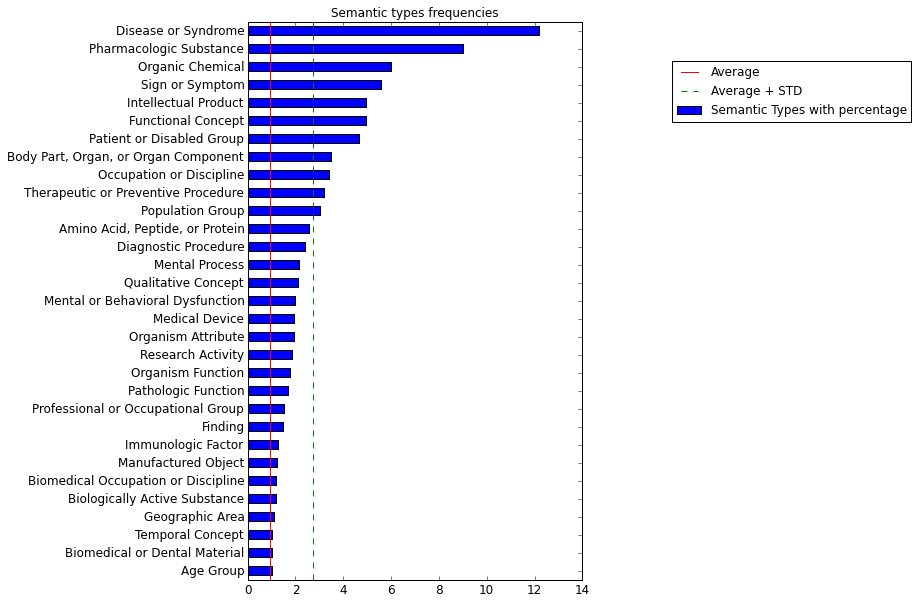

In [21]:
data_dir = __mkdir(working_dir, "data")
st_df = pd.read_pickle(os.path.join(data_dir, 'stypes_percentage.pckl'))
plot(st_df, PLOT_CONF)

